Hücre 0 — Güvenli kurulum (v3)

In [1]:
# === Güvenli Kurulum (Kaggle) v3 ===
# torch/torchvision/pandas zaten yüklü; onları kurmuyoruz.

import sys, subprocess, warnings
def pipi(*pkgs): subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + list(pkgs))

# Gürültü çıkaran paketleri kaldır (varsa)
!pip -q uninstall -y cesium dopamine-rl category-encoders sklearn-compat scikit-learn || true

# Sürüm sabitle
!pip -q install "numpy<2" --force-reinstall --no-deps
pipi("opencv-python==4.8.1.78")
pipi("albumentations==1.4.7", "--no-deps")
pipi("scikit-learn==1.5.2", "--no-deps")   # albumentations bazı modüllerde ister
pipi("scikit-image<0.23", "--no-deps")     # match_histograms vs. için

# Sürümleri yazdır
import numpy, cv2, albumentations, torch, torchvision, pandas as pd, sklearn, skimage
print("numpy         :", numpy.__version__)
print("opencv        :", cv2.__version__)
print("albumentations:", albumentations.__version__)
print("scikit-learn  :", sklearn.__version__)
print("scikit-image  :", skimage.__version__)
print("torch         :", torch.__version__, "| torchvision:", torchvision.__version__)
print("pandas        :", pd.__version__)

# Gürültülü uyarıları kıs
warnings.filterwarnings("ignore", message="PydanticSerializationUnexpectedValue")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 104.6 MB/s eta 0:00:00
numpy         : 1.26.4
opencv        : 4.8.1
albumentations: 1.4.7
scikit-learn  : 1.5.2
scikit-image  : 0.22.0
torch         : 2.6.0+cu124 | torchvision: 0.21.0+cu124
pandas        : 2.2.3


In [2]:
import os, json, random
from pathlib import Path
from collections import defaultdict, Counter

import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import albumentations as A
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (6,4)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [3]:
INPUT = Path("/kaggle/input")

def find_first(*subpaths):
    """ /kaggle/input altında ilk bulunan yolu döndür. """
    for root in INPUT.iterdir():
        if not root.is_dir(): continue
        for sp in subpaths:
            p = root / sp
            if p.exists():
                return p
    return None

# Adayları bul
ANN_DIR   = find_first("2017-2017/annotations_trainval2017/annotations",
                       "annotations_trainval2017/annotations")
TRAIN_DIR = find_first("2017-2017/train2017", "train2017")
VAL_DIR   = find_first("2017-2017/val2017",   "val2017")
TEST_DIR  = find_first("2017-2017/test2017/test2017", "test2017/test2017", "test2017")

# Nested klasörleri yakala (train2017/train2017 gibi)
def resolve_nested(p: Path|None, inner: str) -> Path|None:
    if p is None: return None
    return (p/inner) if (p/inner).exists() else p

TRAIN_DIR = resolve_nested(TRAIN_DIR, "train2017")
VAL_DIR   = resolve_nested(VAL_DIR,   "val2017")
TEST_DIR  = resolve_nested(TEST_DIR,  "test2017")

print("ANN_DIR  ->", ANN_DIR)
print("TRAIN_DIR->", TRAIN_DIR)
print("VAL_DIR  ->", VAL_DIR)
print("TEST_DIR ->", TEST_DIR)


ANN_DIR  -> /kaggle/input/2017-2017/annotations_trainval2017/annotations
TRAIN_DIR-> /kaggle/input/2017-2017/train2017/train2017
VAL_DIR  -> /kaggle/input/2017-2017/val2017/val2017
TEST_DIR -> /kaggle/input/2017-2017/test2017/test2017


In [4]:
assert ANN_DIR is not None, "Annotations bulunamadı."

with open(ANN_DIR/"instances_train2017.json","r") as f: train_ann = json.load(f)
with open(ANN_DIR/"instances_val2017.json","r")   as f: val_ann   = json.load(f)

cat_id_to_name = {c["id"]: c["name"] for c in train_ann["categories"]}
class_ids_sorted = sorted(cat_id_to_name.keys())
class_names = [cat_id_to_name[i] for i in class_ids_sorted]
cat_id_to_index = {cid:i for i,cid in enumerate(class_ids_sorted)}
NUM_CLASSES = len(class_names)
print("Sınıf sayısı:", NUM_CLASSES, "| örnek:", class_names[:10])

def build_items(ann):
    imgid_to_file = {im["id"]: im["file_name"] for im in ann["images"]}
    imgid_to_labels = defaultdict(set)
    for a in ann["annotations"]:
        imgid_to_labels[a["image_id"]].add(cat_id_to_index[a["category_id"]])
    items = []
    for img_id, fname in imgid_to_file.items():
        vec = np.zeros(NUM_CLASSES, dtype=np.float32)
        for idx in imgid_to_labels[img_id]: vec[idx]=1.0
        items.append((fname, vec))
    return items

train_items = build_items(train_ann)
val_items   = build_items(val_ann)

# --- Dizini bir kez listeleyip hızlı filtre yapalım (exists() yok) ---
import os, time

def fast_filter_items(items, img_dir: Path|None):
    if img_dir is None:
        return []
    names = set(f for f in os.listdir(img_dir) if f.endswith(".jpg"))
    return [(fname, vec) for (fname, vec) in items if fname in names]

t0 = time.time()
train_items = fast_filter_items(train_items, TRAIN_DIR)
val_items   = fast_filter_items(val_items,   VAL_DIR)
print(f"Filtreleme süresi: {time.time()-t0:.2f}s")
print(f"Mevcut TRAIN örnek sayısı: {len(train_items)}")
print(f"Mevcut VAL   örnek sayısı: {len(val_items)}")

if len(train_items)==0 or len(val_items)==0:
    print("\nUYARI: train/val klasörlerinde jpg bulunamadı.")
    print("Sağ panelde '2017-2017' altında şu yapıyı doğrula:")
    print("  train2017/train2017/*.jpg  ve  val2017/val2017/*.jpg")


Sınıf sayısı: 80 | örnek: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light']
Filtreleme süresi: 1.10s
Mevcut TRAIN örnek sayısı: 118287
Mevcut VAL   örnek sayısı: 5000


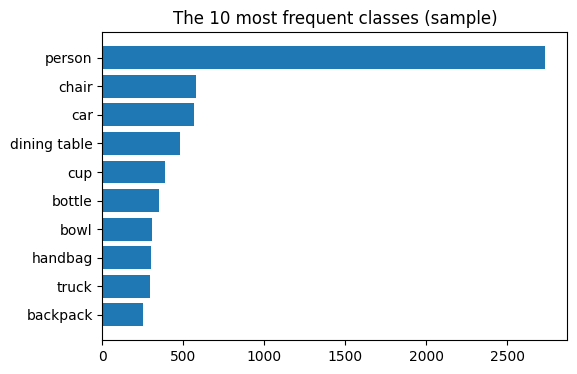

In [5]:
from collections import Counter
def count_labels(items, sample=5000):
    cnt = Counter()
    for _, vec in random.sample(items, min(sample, len(items))):
        cnt.update(np.where(vec==1)[0].tolist())
    return cnt

if len(train_items)>0:
    top10 = count_labels(train_items).most_common(10)
    labels = [class_names[i] for i,_ in top10]
    values = [v for _,v in top10]
    plt.barh(labels, values); plt.title("The 10 most frequent classes (sample)"); plt.gca().invert_yaxis(); plt.show()


In [6]:
IMG_SIZE = 256

train_aug = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.ColorJitter(brightness=(0.9,1.1), contrast=(0.9,1.1),
                  saturation=(0.9,1.1), hue=(-0.05,0.05), p=0.3),
])

val_aug = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
])

to_tensor = transforms.ToTensor()

class CocoMultiLabel(Dataset):
    def __init__(self, root_dir: Path, items, aug):
        self.root_dir, self.items, self.aug = root_dir, items, aug
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        fname, target = self.items[i]
        p = self.root_dir / fname
        img = cv2.imread(str(p))
        if img is None: img = np.zeros((IMG_SIZE,IMG_SIZE,3), np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.aug(image=img)["image"]
        x = to_tensor(img)              # [0,1]
        y = torch.from_numpy(target)    # multi-hot
        return x, y, fname

assert len(train_items)>0 and len(val_items)>0, "Train/Val görüntüleri bulunamadı. Hücre 3 uyarısına bak."
N_TRAIN = min(20000, len(train_items))
N_VAL   = min( 5000, len(val_items))
random.shuffle(train_items); random.shuffle(val_items)
train_sel, val_sel = train_items[:N_TRAIN], val_items[:N_VAL]
print(f"Eğitime alınacak: train={len(train_sel)} | val={len(val_sel)}")

train_ds = CocoMultiLabel(TRAIN_DIR, train_sel, train_aug)
val_ds   = CocoMultiLabel(VAL_DIR,   val_sel,   val_aug)

BATCH = 64
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


Eğitime alınacak: train=20000 | val=5000


In [7]:
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(c_out)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class TinyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem  = nn.Sequential(ConvBlock(3,32), ConvBlock(32,32), nn.MaxPool2d(2), nn.Dropout(0.1))
        self.s2    = nn.Sequential(ConvBlock(32,64), ConvBlock(64,64), nn.MaxPool2d(2), nn.Dropout(0.2))
        self.s3    = nn.Sequential(ConvBlock(64,128),ConvBlock(128,128),nn.MaxPool2d(2), nn.Dropout(0.3))
        self.s4    = nn.Sequential(ConvBlock(128,256), nn.AdaptiveAvgPool2d(1))
        self.head  = nn.Sequential(nn.Flatten(), nn.Linear(256,256), nn.ReLU(True), nn.Dropout(0.4), nn.Linear(256,num_classes))
    def forward(self, x):
        x = self.stem(x); x = self.s2(x); x = self.s3(x); feats = self.s4(x)
        logits = self.head(feats)
        return logits, feats

model = TinyCNN(NUM_CLASSES).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print("Model hazır.")


Model hazır.


In [8]:
x = torch.randn(2,3,IMG_SIZE,IMG_SIZE).to(device)
logits, feats = model(x)
print("logits:", logits.shape, "| feats:", feats.shape)


logits: torch.Size([2, 80]) | feats: torch.Size([2, 256, 1, 1])


In [9]:
def epoch_loop(dl, train=True):
    model.train(mode=train)
    tot_loss, tot = 0.0, 0
    y_true, y_score = [], []
    with torch.set_grad_enabled(train):
        for xb, yb, _ in tqdm(dl, leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            tot_loss += loss.item()*xb.size(0); tot += xb.size(0)
            y_true.append(yb.detach().cpu()); y_score.append(torch.sigmoid(logits).detach().cpu())
    return tot_loss/max(1,tot), torch.cat(y_true), torch.cat(y_score)

def multilabel_f1(y_true, y_score, thresh=0.5, eps=1e-9):
    y_pred = (y_score>=thresh).float()
    tp = (y_true*y_pred).sum(0); fp=((1-y_true)*y_pred).sum(0); fn=(y_true*(1-y_pred)).sum(0)
    f1 = (2*tp)/(2*tp+fp+fn+eps)
    return f1.mean().item()


In [10]:
# === Hücre 9 (YENİ): Eğitim + en iyi global threshold arama ===
import numpy as np

EPOCHS = 5
hist = []
best_loss = float("inf")
BEST_PATH = "/kaggle/working/best_tinycnn.pt"
last_va_y = None; last_va_s = None  # threshold araması için saklayacağız

for ep in range(1, EPOCHS+1):
    tr_loss, _, _        = epoch_loop(train_dl, train=True)
    va_loss, va_y, va_s  = epoch_loop(val_dl,   train=False)
    last_va_y, last_va_s = va_y, va_s
    va_f1 = multilabel_f1(va_y, va_s, thresh=0.5)  # sadece raporlamak için
    hist.append((ep, tr_loss, va_loss, va_f1))
    print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  val_F1@0.5={va_f1:.4f}")
    if va_loss < best_loss:
        best_loss = va_loss
        torch.save(model.state_dict(), BEST_PATH)

# --- threshold araması (0.05..0.5 arası 10 aday) ---
def f1_at_thresh(y_true, y_score, t):
    y_pred = (y_score >= t).float()
    tp = (y_true*y_pred).sum(0); fp=((1-y_true)*y_pred).sum(0); fn=(y_true*(1-y_pred)).sum(0)
    f1 = (2*tp)/(2*tp+fp+fn+1e-9)
    return f1.mean().item()

cands = np.linspace(0.05, 0.5, 10)
f1s   = [f1_at_thresh(last_va_y, last_va_s, t) for t in cands]
best_idx = int(np.argmax(f1s))
best_t   = float(cands[best_idx])
print(f"\nGlobal threshold arandı: en iyi t={best_t:.2f} | val_F1={f1s[best_idx]:.4f}")


Epoch 01 | train_loss=0.1491  val_loss=0.1283  val_F1@0.5=0.0083


Epoch 02 | train_loss=0.1275  val_loss=0.1288  val_F1@0.5=0.0109


Epoch 03 | train_loss=0.1228  val_loss=0.1193  val_F1@0.5=0.0107


Epoch 04 | train_loss=0.1198  val_loss=0.1179  val_F1@0.5=0.0078


Epoch 05 | train_loss=0.1169  val_loss=0.1148  val_F1@0.5=0.0123

Global threshold arandı: en iyi t=0.10 | val_F1=0.1635


In [11]:
# === Hücre 9.1: Sınıf dengesizliği için pos_weight + kısa ek eğitim ===
def compute_pos_weight(items, n_images):
    sum_pos = np.sum([vec for _, vec in items], axis=0)   # sınıf başına pozitif sayısı
    sum_neg = n_images - sum_pos
    pw = sum_neg / (sum_pos + 1e-6)
    pw = np.clip(pw, 1.0, 20.0)  # aşırı uçları kırp
    return torch.tensor(pw, dtype=torch.float32)

pos_weight = compute_pos_weight(train_sel, len(train_sel)).to(device)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # KAYBI güncelledik
optimizer  = torch.optim.Adam(model.parameters(), lr=5e-4)  # LR'ı biraz düşürdük

EPOCHS_EXTRA = 5
for ep in range(1, EPOCHS_EXTRA+1):
    tr_loss, _, _ = epoch_loop(train_dl, train=True)
    va_loss, va_y, va_s = epoch_loop(val_dl, train=False)
    va_f1 = f1_at_thresh(va_y, va_s, best_t)  # en iyi threshold ile raporla
    print(f"[pos_weight] Epoch {ep:02d} | train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  val_F1@t={best_t:.2f} => {va_f1:.4f}")


[pos_weight] Epoch 01 | train_loss=0.7278  val_loss=0.6777  val_F1@t=0.10 => 0.0941


[pos_weight] Epoch 02 | train_loss=0.6850  val_loss=0.6768  val_F1@t=0.10 => 0.0994


[pos_weight] Epoch 03 | train_loss=0.6727  val_loss=0.7040  val_F1@t=0.10 => 0.1031


[pos_weight] Epoch 04 | train_loss=0.6641  val_loss=0.6712  val_F1@t=0.10 => 0.1006


[pos_weight] Epoch 05 | train_loss=0.6548  val_loss=0.6623  val_F1@t=0.10 => 0.1049


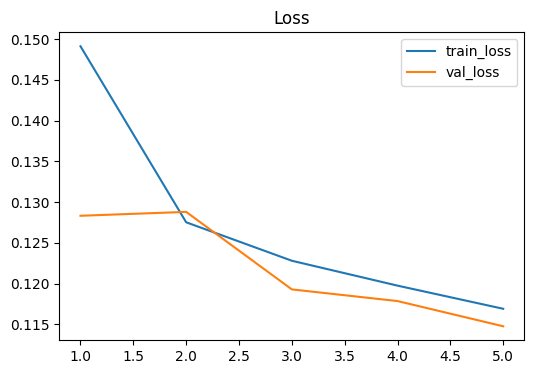

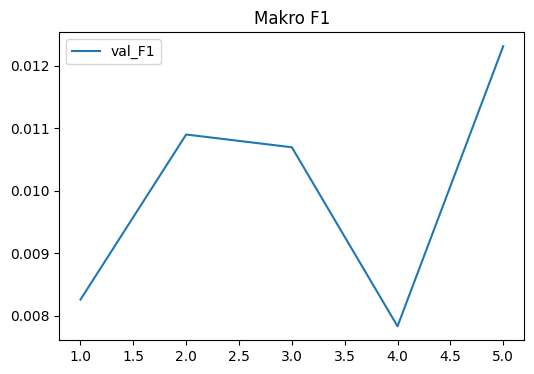

In [12]:
ep, trl, vall, f1s = zip(*hist)
plt.plot(ep, trl, label="train_loss"); plt.plot(ep, vall, label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()
plt.plot(ep, f1s, label="val_F1"); plt.legend(); plt.title("Makro F1"); plt.show()


In [13]:
def top_words(sig, k=5, thresh=0.45):
    s = sig.numpy(); idxs = np.where(s>=thresh)[0]
    if len(idxs)==0: idxs = np.argsort(-s)[:k]
    return [(class_names[i], float(s[i])) for i in idxs]

for i in range(5):
    x, y, fname = val_ds[i]
    with torch.no_grad():
        s,_ = model(x.unsqueeze(0).to(device))
        s = torch.sigmoid(s).cpu().squeeze(0)
    print(fname, "→", top_words(s))


000000268378.jpg → [('person', 0.7687118649482727), ('backpack', 0.5320060849189758), ('umbrella', 0.45871785283088684), ('handbag', 0.7055481672286987), ('tie', 0.573491096496582), ('bottle', 0.8087598085403442), ('wine glass', 0.7485197186470032), ('cup', 0.8299158215522766), ('fork', 0.6838967800140381), ('knife', 0.7827903628349304), ('spoon', 0.7017333507537842), ('bowl', 0.7876690030097961), ('banana', 0.5020971298217773), ('orange', 0.5206007361412048), ('pizza', 0.6364271640777588), ('cake', 0.6613994836807251), ('chair', 0.791598916053772), ('couch', 0.6451697945594788), ('potted plant', 0.6625671982765198), ('dining table', 0.8205463886260986), ('tv', 0.6494625806808472), ('laptop', 0.5176519155502319), ('remote', 0.5685018301010132), ('cell phone', 0.6859230399131775), ('oven', 0.5106765031814575), ('sink', 0.5046044588088989), ('refrigerator', 0.5552439093589783), ('book', 0.7309423685073853), ('clock', 0.5721448659896851), ('vase', 0.6698639392852783), ('teddy bear', 0.517

In [14]:
# === Hücre 12 (YENİ): test2017 için tahmin & manifest.csv (best_t ile) ===
SAVE_DIR = Path("/kaggle/working/preds"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
assert TEST_DIR is not None and TEST_DIR.exists(), "test2017 bulunamadı."
test_images = list(TEST_DIR.glob("*.jpg"))

THRESH = best_t if 'best_t' in globals() else 0.45
print("Manifest için kullanılacak threshold:", THRESH)

def predict_words_on_image(img_path, thresh=THRESH):
    img = cv2.imread(str(img_path)); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = val_aug(image=img)["image"]
    x = transforms.ToTensor()(x).unsqueeze(0).to(device)
    with torch.no_grad():
        s,_ = model(x); s = torch.sigmoid(s).cpu().numpy()[0]
    idxs = np.where(s >= thresh)[0]
    if len(idxs)==0: idxs = np.argsort(-s)[:5]
    return [class_names[i] for i in idxs], [float(s[i]) for i in idxs]

rows = []
for p in tqdm(test_images[:200]):  # istersen limiti kaldır
    words, scores = predict_words_on_image(p)
    rows.append({"image": p.name, "words": words, "scores": [round(x,3) for x in scores]})

df_manifest = pd.DataFrame(rows)
df_manifest.to_csv(SAVE_DIR/"manifest.csv", index=False)
print("Kaydedildi:", SAVE_DIR/"manifest.csv")


Manifest için kullanılacak threshold: 0.1


100%|██████████| 200/200 [00:04<00:00, 46.51it/s]

Kaydedildi: /kaggle/working/preds/manifest.csv


In [15]:
def draw_words(img_path, words):
    img = cv2.imread(str(img_path))
    for i,t in enumerate(words):
        cv2.putText(img, t, (10,25+i*22), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return img

for p in test_images[:5]:
    ws,_ = predict_words_on_image(p)
    viz = draw_words(p, ws)
    cv2.imwrite(str(SAVE_DIR/f"{p.stem}_words.jpg"), viz)

list(SAVE_DIR.glob("*_words.jpg"))[:5]


[PosixPath('/kaggle/working/preds/000000436639_words.jpg'),
 PosixPath('/kaggle/working/preds/000000355443_words.jpg'),
 PosixPath('/kaggle/working/preds/000000210548_words.jpg'),
 PosixPath('/kaggle/working/preds/000000196829_words.jpg'),
 PosixPath('/kaggle/working/preds/000000081349_words.jpg')]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


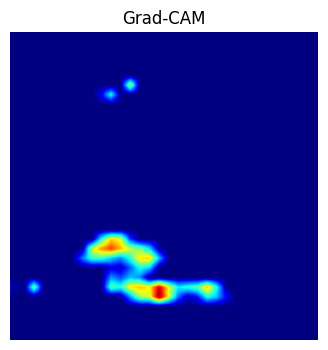

In [16]:
target_layer = dict(model.named_modules())["s4.0.conv"]
acts, grads = None, None
def fwd_hook(m,i,o):  # activations
    global acts; acts = o.detach()
def bwd_hook(m,gi,go):  # gradients
    global grads; grads = go[0].detach()
_ = target_layer.register_forward_hook(fwd_hook)
_ = target_layer.register_backward_hook(bwd_hook)

def grad_cam_image(img_rgb):
    model.eval()
    x = val_aug(image=img_rgb)["image"]; x = transforms.ToTensor()(x).unsqueeze(0).to(device)
    x.requires_grad=True
    logits,_ = model(x)
    probs = torch.sigmoid(logits)[0]; target_idx = int(torch.argmax(probs))
    score = logits[0, target_idx]
    model.zero_grad(); score.backward(retain_graph=True)
    A, G = acts, grads
    w = G.mean(dim=(2,3), keepdim=True)
    cam = (A*w).sum(dim=1, keepdim=True)
    cam = F.relu(cam)[0,0].cpu().numpy()
    cam = (cam-cam.min())/(cam.max()-cam.min()+1e-9)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    heat = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    return heat

p = test_images[0]
orig = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
heat = grad_cam_image(orig)
plt.imshow(cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Grad-CAM"); plt.show()


readme = f"""
# Kelime Öğrenme için Çok-Etiketli Görüntü Sınıflandırma (COCO 2017)

**Amaç:** Görüntüdeki nesnelerin İngilizce isimlerini listeleyen, YOLO kullanmadan sıfırdan CNN tabanlı sistem.

## Veri
- COCO 2017 train/val/test

## Yöntem
- Çok-etiketli sınıflandırma (multi-label)
- TinyCNN (Conv+BN+ReLU, Pooling, Dropout, Dense)
- BCEWithLogitsLoss + Adam
- Augmentations: Flip, Bright/Contrast, ColorJitter, letterbox

## Değerlendirme
- Loss ve Makro F1 grafikleri
- Grad-CAM ısı haritaları

## Çıktılar
- `/kaggle/working/preds/manifest.csv`
- `_words.jpg` örnek görseller

## Kaggle Notebook
- (kendi linkini ekle)
"""
print(readme)
